In [1]:
import math
import random
import string
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop
from tqdm import tqdm

import precip
import wandb
from precip.data.dataset import InfiniteSampler, SwedishPrecipitationDataset
import matplotlib.pyplot as plt
from precip.models.unet import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [9]:
@dataclass(frozen=True)
class Config:
    model_name: str = "unet_64_multistep"

    # dataset
    forecast_multistep: bool = True
    lookback_start_5_mins_multiple: int = 12 * 12
    lookback_intervals_5_mins_multiple: int = 12
    forecast_horizon_start_5_mins_multiple: int = 1
    forecast_horizon_end_5_mins_multiple: int = 12 * 6
    forecast_intervals_5_mins_multiple: int = 12
    forecast_gap_5_mins_multiple: int = 0

    # training params
    wandb_track: bool = True
    training_batch_size: int = 2
    validation_batch_size: int = 2
    number_of_steps: int = 100
    training_size_per_step: int = 500
    validation_size_per_step: int = 1_000

    # optimizer
    lr: float = 5e-5
    lr_scheduler_step: int = 3
    lr_scheduler_gamma: float = 0.85
    weight_decay: float = 1e-9

    # checkpoint
    intermediate_checkpointing: bool = True
    load_from_checkpoint: bool = True
    checkpoint_frequency: int = 10
    checkpoint_path: Path = Path("checkpoints/colorful-disco-1323ORW3/step_num_30.pth")


def get_training_config() -> Config:
    return Config()

config = get_training_config()
path_to_state = Path(
    'checkpoints/breezy-salad-1456KQAG/step_num_70.pth'
)

training_dataset = SwedishPrecipitationDataset(
    split="train",
    forecast_multistep=config.forecast_multistep,
    lookback_start_5_mins_multiple=config.lookback_start_5_mins_multiple,
    lookback_intervals_5_mins_multiple=config.lookback_intervals_5_mins_multiple,
    forecast_horizon_start_5_mins_multiple=config.forecast_horizon_start_5_mins_multiple,
    forecast_horizon_end_5_mins_multiple=config.forecast_horizon_end_5_mins_multiple,
    forecast_intervals_5_mins_multiple=config.forecast_intervals_5_mins_multiple,
    forecast_gap_5_mins_multiple=config.forecast_gap_5_mins_multiple,
)
validation_dataset = SwedishPrecipitationDataset(
    split="val",
    forecast_multistep=config.forecast_multistep,
    lookback_start_5_mins_multiple=config.lookback_start_5_mins_multiple,
    lookback_intervals_5_mins_multiple=config.lookback_intervals_5_mins_multiple,
    forecast_horizon_start_5_mins_multiple=config.forecast_horizon_start_5_mins_multiple,
    forecast_horizon_end_5_mins_multiple=config.forecast_horizon_end_5_mins_multiple,
    forecast_intervals_5_mins_multiple=config.forecast_intervals_5_mins_multiple,
    forecast_gap_5_mins_multiple=config.forecast_gap_5_mins_multiple,
)
output_transform = CenterCrop((256, 256))
training_dataloader = DataLoader(
    dataset=training_dataset,
    sampler=InfiniteSampler(training_dataset),
    batch_size=config.training_batch_size,
)
validation_dataloader = DataLoader(
    dataset=validation_dataset,
    sampler=InfiniteSampler(validation_dataset),
    batch_size=config.validation_batch_size,
)
train_dataiter = iter(training_dataloader)
val_dataiter = iter(validation_dataloader)

In [4]:
payload = torch.load(path_to_state)
model = UNet(
    training_dataset.lookback_start_5_mins_multiple
    // training_dataset.lookback_intervals_5_mins_multiple,
    1,
    base_channels=64,
).to('cuda')
model.load_state_dict(payload['model_state_dict'])
model = model.to(device)
model = model.eval()

In [5]:
with torch.no_grad():
    (batch_X, batch_y) = next(train_dataiter)
    batch_X, batch_y = batch_X.to(device), batch_y.squeeze(dim=1).to(device)

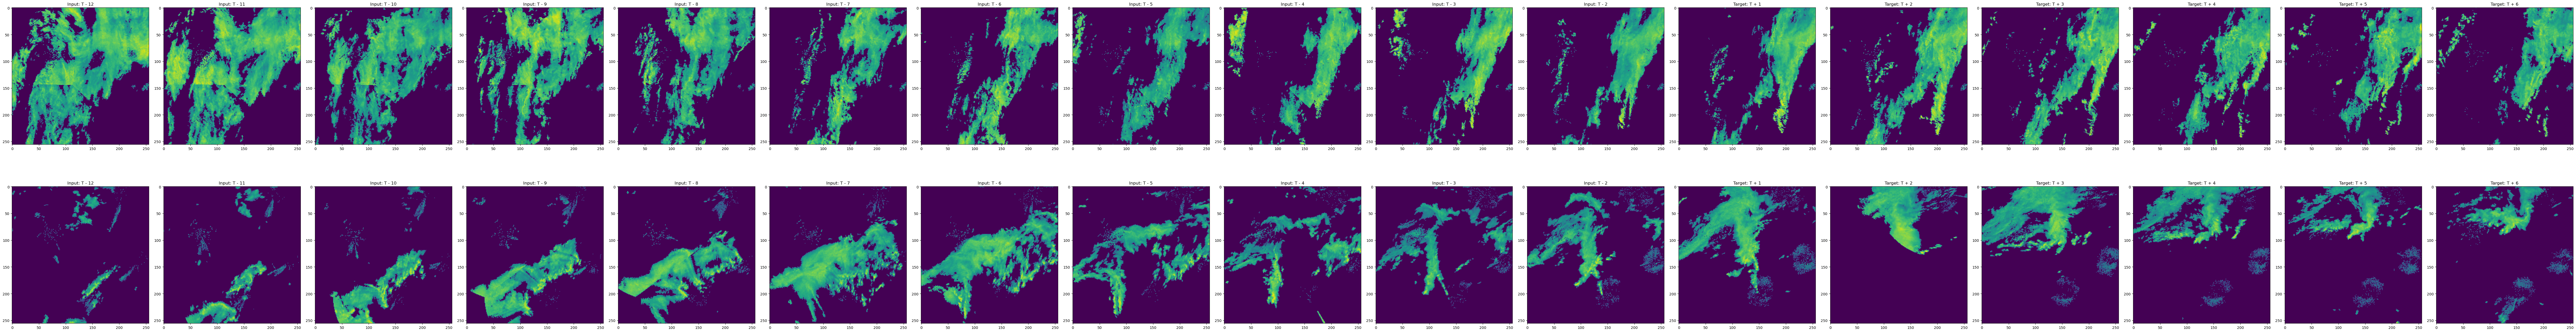

In [6]:
b = batch_X.size(0)

f, axes = plt.subplots(b, batch_X.size(1) + batch_y.size(1) - 1, figsize=(100, 15))

for _b in range(b):
    _X, _y = batch_X[_b], batch_y[_b]
    for x_index in range(_X.shape[0]):
        axes[_b, x_index].imshow(_X[x_index].cpu().numpy())
        axes[_b, x_index].set_title(f'Input: T - {_X.shape[0] - x_index}')

    for y_index in range(_y.shape[0]):
        axes[_b, x_index + y_index].imshow(_y[y_index].cpu().numpy())
        axes[_b, x_index + y_index].set_title(f'Target: T + {y_index + 1}')
        
f.tight_layout()

In [7]:
model.train()
loss_history = list()
loss = nn.MSELoss()

forecasts = list()
(batch_X, batch_y) = next(train_dataiter)
batch_X, batch_y = batch_X.to(device), batch_y.to(device)
with torch.no_grad():
    for forecast_step in range(batch_y.size(1)):
        out = model(batch_X).unsqueeze(1)
        forecasts.append(out)

        # update the input frame to the model
        # drop the earliest observation (0th index)
        batch_X = torch.cat([batch_X[:, 1:, ...], out], dim=1)

    forecasts = torch.cat(forecasts, dim=1)

    # optimizer.zero_grad()
    _loss = loss(output_transform(forecasts), output_transform(batch_y))
    # _loss.backward()
    # optimizer.step()
    loss_history.append(math.sqrt(_loss.item()))

[34.3732954122819]


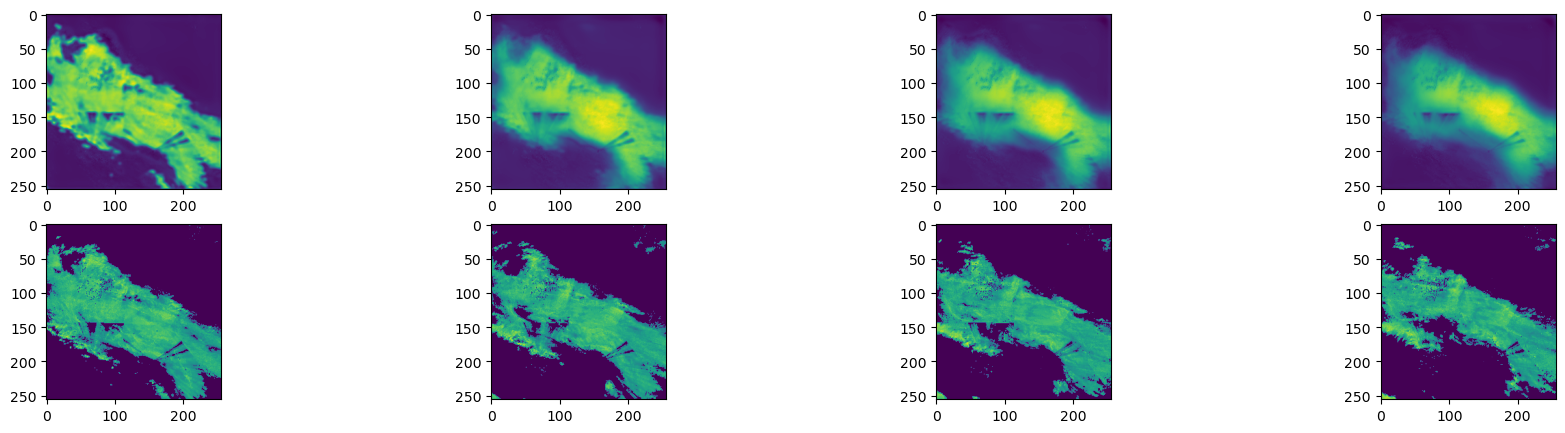

In [29]:
model.train()
loss_history = list()
loss = nn.MSELoss()

forecasts = list()
(batch_X, batch_y) = next(train_dataiter)
batch_X, batch_y = batch_X.to(device), batch_y.to(device)
with torch.no_grad():
    for forecast_step in range(batch_y.size(1)):
        out = model(batch_X).unsqueeze(1)
        forecasts.append(out)

        # update the input frame to the model
        # drop the earliest observation (0th index)
        batch_X = torch.cat([batch_X[:, 1:, ...], out], dim=1)

    forecasts = torch.cat(forecasts, dim=1)

    # optimizer.zero_grad()
    _loss = loss(output_transform(forecasts), output_transform(batch_y))
    # _loss.backward()
    # optimizer.step()
    loss_history.append(math.sqrt(_loss.item()))

_f, axes = plt.subplots(2, 4, figsize=(22, 5))

print(loss_history)

for index in range(4):
    axes[0, index].imshow(output_transform(forecasts[0, index]).detach().cpu().numpy())
    axes[1, index].imshow(output_transform(batch_y[0, index]).detach().cpu().numpy())

In [10]:
loss_history

[21.629969031478858,
 26.637476903439072,
 21.800306349535408,
 23.354666122372635,
 32.05100381740212,
 27.938753991711494,
 26.603910735195495,
 27.44488662315464,
 23.872281064503582,
 27.005429322464494,
 18.030441821413877,
 41.65889168996143,
 24.03123349113542,
 33.84741799721398,
 22.97946444399461,
 34.11326134525069,
 21.08177177265276,
 42.148735083518524,
 27.891189595125734,
 24.18031602575675,
 28.450336216983008,
 37.24076739084971,
 24.490077909545835,
 26.862785650964934,
 26.150387634555248,
 22.475878861909592,
 26.027013976692924,
 28.54651794043255,
 19.753195202374854,
 18.774872012660882,
 25.722501719828156,
 22.393481586794962,
 37.32355298497016,
 28.457888896221508,
 21.82254313025581,
 33.44445021225495,
 27.849700805591027,
 21.396632619437383,
 28.91962739443253,
 18.827839728129327,
 19.81812906775243,
 20.0943901470251,
 23.17931095919309,
 25.600586216890378,
 25.727048849031807,
 19.16837194845449,
 23.890466603464446,
 22.79044846016912,
 28.620711759

In [9]:
model.train()
loss_history = list()
number_of_batches = 50
with torch.no_grad():
    for _ in tqdm(range(number_of_batches)): 
        forecasts = list()
        (batch_X, batch_y) = next(val_dataiter)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        for forecast_step in range(batch_y.size(1)):
            out = model(batch_X).unsqueeze(1)
            forecasts.append(out)

            # update the input frame to the model
            # drop the earliest observation (0th index)
            batch_X = torch.cat([batch_X[:, 1:, ...], out], dim=1)

        forecasts = torch.cat(forecasts, dim=1)

        # optimizer.zero_grad()
        _loss = loss(output_transform(forecasts), output_transform(batch_y))
        # _loss.backward()
        # optimizer.step()
        loss_history.append(math.sqrt(_loss.item()))

100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


In [80]:
with torch.no_grad():
    model.eval()
    validation_loss_history = list()

    for _ in tqdm(range(100)):
        forecasts = list()
        (batch_X, batch_y) = next(train_dataiter)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        for forecast_step in range(batch_y.size(1)):
            out = model(batch_X).unsqueeze(1)
            forecasts.append(out)

            # update the input frame to the model
            # drop the earliest observation (0th index)
            batch_X = torch.cat([batch_X[:, 1:, ...], out], dim=1)

        forecasts = torch.cat(forecasts, dim=1)
        _loss = loss(output_transform(forecasts), output_transform(batch_y))
        validation_loss_history.append(math.sqrt(_loss.item()))
        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [81]:
validation_loss_history

[41.47394230869547]

In [110]:
model.train()
loss_history = list()
loss = nn.MSELoss()

forecasts = list()
(batch_X, batch_y) = next(val_dataiter)
batch_X, batch_y = batch_X.to(device), batch_y.to(device)
with torch.no_grad():
    for forecast_step in range(batch_y.size(1)):
        out = model(batch_X).unsqueeze(1)
        forecasts.append(out)

        # update the input frame to the model
        # drop the earliest observation (0th index)
        batch_X = torch.cat([batch_X[:, 1:, ...], out], dim=1)

    forecasts = torch.cat(forecasts, dim=1)

    # optimizer.zero_grad()
    _loss = loss(output_transform(forecasts), output_transform(batch_y))
    # _loss.backward()
    # optimizer.step()
    loss_history.append(math.sqrt(_loss.item()))

In [111]:
loss_history

[30.232221943686902]

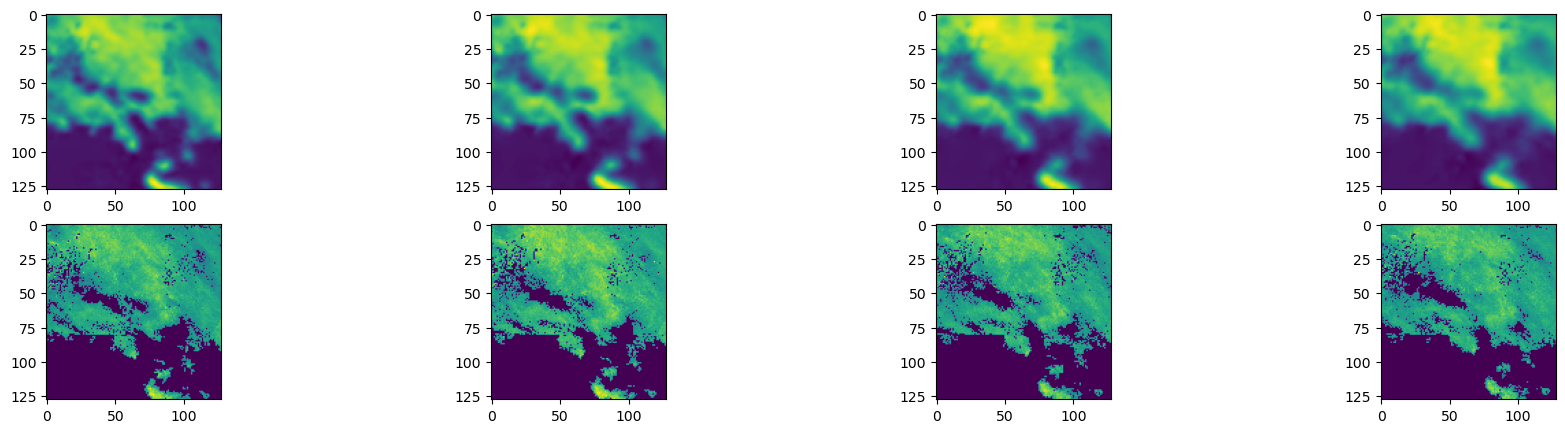

In [112]:
_f, axes = plt.subplots(2, 4, figsize=(22, 5))

for index in range(4):
    axes[0, index].imshow(output_transform(forecasts[0, index]).detach().cpu().numpy())
    axes[1, index].imshow(output_transform(batch_y[0, index]).detach().cpu().numpy())

In [14]:
loss_history

[23.539521444248155,
 23.6460758236006,
 33.41772743374297,
 29.880476828655404,
 30.504382209518273,
 27.736665838487824,
 25.31463146890055,
 28.386362632364396,
 18.87437912886143,
 42.90075586182165,
 24.914254810719054,
 35.26746298378294,
 23.43340979934885,
 36.93157405404453,
 21.939169274097413,
 44.3822328502458,
 29.153050090682513,
 24.882955994484206,
 29.77603881971154,
 39.712871749814155,
 25.771439894926562,
 29.154377410055744,
 27.406434844730125,
 23.703817660446333,
 27.581743300171627,
 29.924774459715543,
 21.698790148219885,
 19.625981980557608,
 27.03278761884006,
 23.733581650252848,
 39.77797880305446,
 30.658408117207422,
 23.310809935806205,
 34.99659756062455,
 29.48828720070479,
 22.139907556080647,
 29.924121774328544,
 28.639376166171985,
 20.85629658932465,
 21.489342465501576,
 24.07313837477236,
 26.371255473230224,
 26.852868340010485,
 19.9766648535704,
 24.542909997641758,
 24.062817063657832,
 30.038958874983813,
 32.46787775536769,
 29.538627550

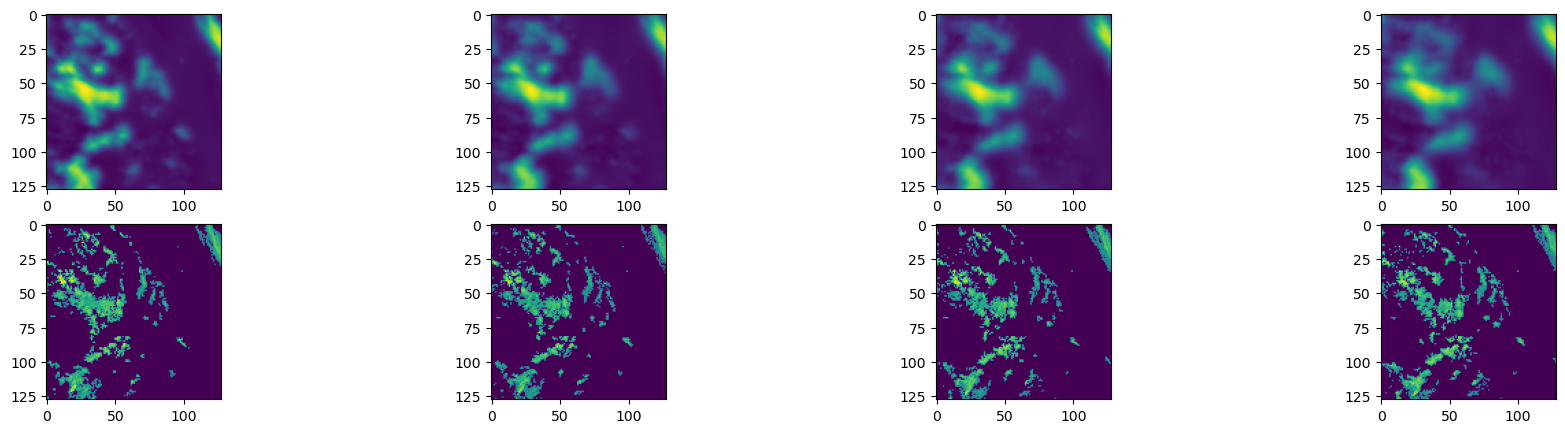

In [15]:
_f, axes = plt.subplots(2, 4, figsize=(22, 5))

for index in range(4):
    axes[0, index].imshow(output_transform(forecasts[0, index]).detach().cpu().numpy())
    axes[1, index].imshow(output_transform(batch_y[0, index]).detach().cpu().numpy())

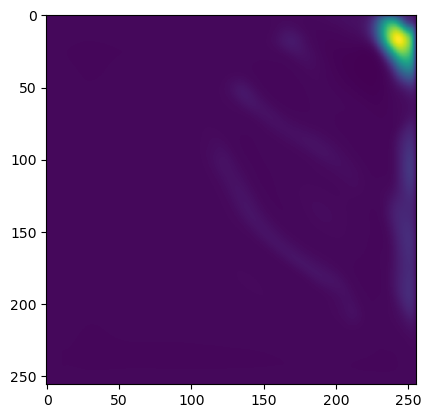

In [21]:
plt.imshow(batch_X.cpu().numpy()[1, 4])

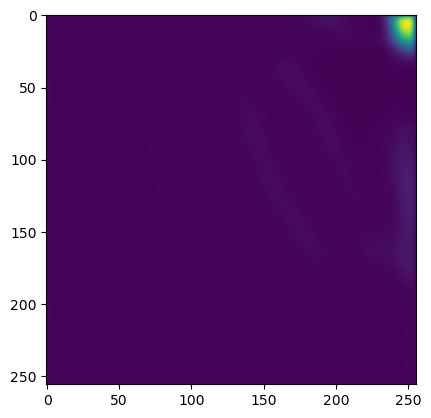

In [24]:
plt.imshow(out.detach().cpu().numpy()[0, 0])

In [12]:
with torch.no_grad():
    batch_X

tensor([[[[-8.4038e-02, -1.5898e-01, -7.8373e-02,  ...,  1.9712e+02,
            1.5536e+02,  8.6567e+01],
          [-1.3360e-01, -2.1796e-01, -9.7695e-02,  ...,  3.5492e+02,
            2.7924e+02,  1.5638e+02],
          [-8.9769e-02, -1.2044e-01,  4.1168e-02,  ...,  4.5935e+02,
            3.6022e+02,  2.0136e+02],
          ...,
          [-2.1345e-01, -2.7653e-01, -8.7992e-02,  ...,  5.7937e-01,
            3.9806e-01,  1.6209e-01],
          [-2.4187e-01, -3.1058e-01, -1.3045e-01,  ...,  4.5751e-01,
            2.9160e-01,  1.0240e-01],
          [-2.3081e-01, -2.7434e-01, -1.4863e-01,  ...,  2.0154e-01,
            1.1077e-01,  2.5922e-02]],

         [[-7.4598e-02, -1.4122e-01, -5.6214e-02,  ...,  2.0878e+02,
            1.6465e+02,  9.1764e+01],
          [-1.1675e-01, -1.8677e-01, -5.9053e-02,  ...,  3.7561e+02,
            2.9569e+02,  1.6564e+02],
          [-7.0557e-02, -8.4787e-02,  8.5646e-02,  ...,  4.8554e+02,
            3.8094e+02,  2.1299e+02],
          ...,
     

In [26]:
t = torch.cat([torch.ones(5, 5).unsqueeze(0), torch.ones(5,5).unsqueeze(0) * 2])
m = lambda x: x[-1] + 1.0

In [27]:
forecasts = list()
inputs = list()
outputs = list()
outs = list()

for _t in range(len(t)):
    inputs.append(t)
    out = m(t).unsqueeze(0)
    t = torch.cat([t[1:, ...], out], dim=0)
    
    outputs.append(t)
    outs.append(out)

In [28]:
inputs[0]

tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.]]])

In [29]:
inputs[1]

tensor([[[2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.]],

        [[3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.]]])

In [30]:
outs

[tensor([[[3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.]]]),
 tensor([[[4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.]]])]

In [31]:
outputs

[tensor([[[2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.]],
 
         [[3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.]]]),
 tensor([[[3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.]],
 
         [[4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.]]])]

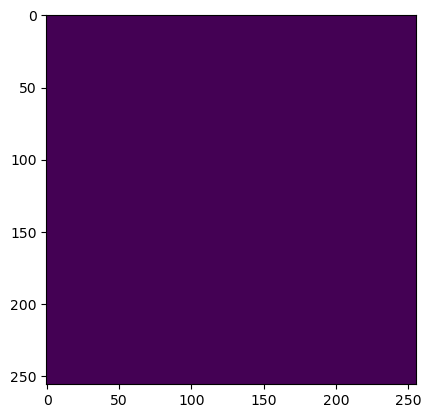

In [14]:
plt.imshow((forecasts[0, 0] - forecasts[0, 1]).cpu().numpy())

In [17]:
((forecasts[0, 0] - forecasts[0, 1]) == 0).all()

tensor(True, device='cuda:0')

In [22]:
batch_X.shape

torch.Size([10, 12, 256, 256])

In [23]:
out.shape

torch.Size([10, 1, 256, 256])

In [30]:
torch.cat([batch_X[:, 1:, ...], out], dim=1).shape

torch.Size([10, 12, 256, 256])